In [27]:
import numpy as np
import pandas as pd
import sys
import re
import operator
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")
from microbiome_preprocessing import split_tax,filter_taxa_by_prevalence,relative_abundance

### Taxonomy profile pre-processing

In [3]:
path = "/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/centri_report/refseq_custom.mpa"
ab_table,tax_table = split_tax(path)
otu_table = relative_abundance(ab_table)

tax = list(otu_table.index)
idx = [bool(re.search('s__\S+', x)) for x in tax]
otu_table = otu_table[idx]
tax_table = tax_table[idx]
#remove strain level information
rm_tax = list(otu_table.index)
rm_idx = [bool(re.search('s__\S+s__\S+', x)) for x in rm_tax]
idx = list(map(operator.not_, rm_idx))
otu_table = otu_table[idx]
tax_table = tax_table[idx]
#remove low abundance/prevalence taxa
otu_table,tax_table = filter_taxa_by_prevalence(otu_table,tax_table,1)
idx = otu_table.mean(axis=1) > 10 ** -3
otu_table = otu_table[idx]
tax_table = tax_table[idx]


### 16S quantitative comparison

In [6]:
path = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/ground_truth/'
emu_ground_truth = pd.read_csv(path +'emu_mock_ground_truth.csv')
zymo_ground_truth = pd.read_csv(path + 'Zymo_mock_ground_truth.csv')
emu = otu_table.iloc[:,0:2]
zymo = otu_table.iloc[:,2:]

In [7]:
#transform taxonomy name to metaphlan format
emu_idx  = []
for i in emu_ground_truth['Species'] :
    i = i.replace(" ","_") 
    i = 's__' + i
    emu_idx.append(i)
emu_ground_truth.index = emu_idx

zymo_idx= []
for i in zymo_ground_truth['Species'] :
    i = i.replace(" ","_") 
    i = 's__' + i
    zymo_idx.append(i)
zymo_ground_truth.index = zymo_idx

emu_ground_truth.drop('Species', inplace=True, axis=1)
zymo_ground_truth.drop('Species', inplace=True, axis=1)

In [8]:
emu_mock = emu[emu.index.isin(emu_idx)]
emu_fn = list(set(emu_idx) - set(emu_mock.index))
for i in emu_fn :
    emu_mock.loc[i] = [0,0]
emu_mock.loc[:,'Ground_truth'] = emu_ground_truth['Relative_abundance']

zymo_mock = zymo[zymo.index.isin(zymo_idx)]
zymo_fn = list(set(zymo_idx) - set(zymo_mock.index))
for i in zymo_fn :
    zymo_mock.loc[i] = [0,0]
zymo_mock.loc[list(zymo_mock.index),'Ground_truth'] = zymo_ground_truth['Relative_abundance']

/home/bruce1996/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/bruce1996/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/bruce1996/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [9]:
emu_other = emu[emu.index.isin(emu_idx) == False]
emu_other = list(emu_other.sum()) + [0]
emu_mock.loc['Others'] = emu_other
emu_mock['Species'] = list(emu_mock.index)
df = emu_mock.melt(id_vars='Species')

zymo_other = zymo[zymo.index.isin(zymo_idx) == False]
zymo_other = list(zymo_other.sum()) + [0]
zymo_mock.loc['Others'] = zymo_other
zymo_mock['Species'] = list(zymo_mock.index)
zymo_df = zymo_mock.melt(id_vars='Species')

/tmp/ipykernel_1560953/2013868642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_mock['Species'] = list(emu_mock.index)
/tmp/ipykernel_1560953/2013868642.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zymo_mock['Species'] = list(zymo_mock.index)


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

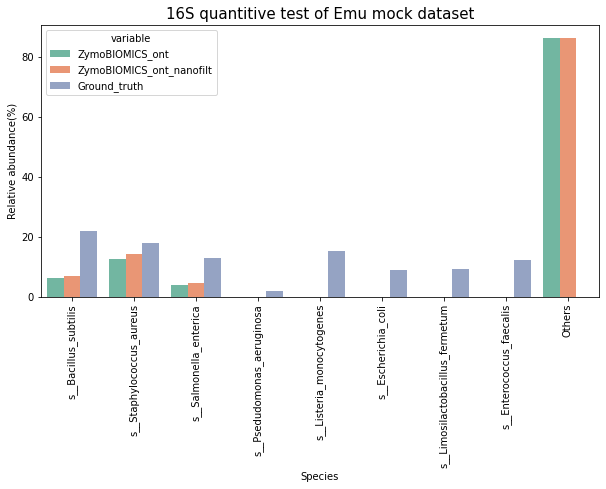

In [13]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Species',y='value',hue='variable',data=zymo_df,palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel('Relative abundance(%)')
plt.title('16S quantitive test of Emu mock dataset',fontsize =15)
plt.savefig('16s_quantitative_test_Emu.png',dpi = 300,bbox_inches = "tight")

### L1 norm

In [143]:
emu_l1 = 0
emu_l1_nano = 0
for i in range(emu_mock.shape[0]) :
    emu_l1 += abs(emu_mock.iloc[i,2] - emu_mock.iloc[i,0])
    emu_l1_nano += abs(emu_mock.iloc[i,2] - emu_mock.iloc[i,1])

zymo_l1 = 0
zymo_l1_nano = 0
for i in range(zymo_mock.shape[0]) :
    zymo_l1 += abs(zymo_mock.iloc[i,2] - zymo_mock.iloc[i,0])
    zymo_l1_nano += abs(zymo_mock.iloc[i,2] - zymo_mock.iloc[i,1])

In [161]:
l1_df = pd.DataFrame({'L1' : [emu_l1,emu_l1_nano,zymo_l1,zymo_l1_nano],
'Dataset' :['Emu','Emu_NanoFilt','ZymoBIOTICS','ZymoBIOTICS_NanoFilt'],
'Quality control' : ['None','NanoFilt','None','NanoFilt']})

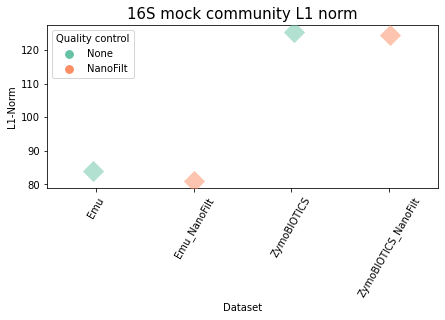

In [165]:
plt.figure(figsize=(7,3))
ax = sns.stripplot(x='Dataset', y='L1',palette="Set2",hue='Quality control',size=15,data=l1_df,marker="D",alpha=.50)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.set_ylabel('L1-Norm')
plt.title('16S mock community L1 norm',fontsize =15)
plt.savefig('tmp/16s_l1.png',dpi = 300,bbox_inches = "tight")

### Zymo mock comparison

In [2]:
report = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/zymo_result.txt'
path = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/ground_truth/'
zymo_ground_truth = pd.read_csv(path + 'Zymo_mock_ground_truth.csv')
zymo_result = pd.read_csv(report,sep="\t",index_col=0,header=None)
zymo_result.columns = ['Relative_abundnace']

In [3]:
zymo_centri_by_emu = pd.read_csv('/home/bruce1996/data/Yi-Fung-Chuang/mock/zymo_genus_by_emu.csv',index_col=0)
new_row = pd.Series(data={'Centrifuge_emu_author':100 - zymo_centri_by_emu.sum()},name='Other')
zymo_centri_by_emu.append(new_row)

,Centrifuge_emu_author
genus,
Bacillus,19.2048
Enterococcus,9.03057
Escherichia,4.53468
Limosilactobacillus,9.15002
Listeria,11.3186
Pseudomonas,2.08702
Salmonella,7.31993
Staphylococcus,15.0556
Other,Centrifuge_emu_author 22.298795 dtype: float64


In [4]:
name = list(zymo_result.index)
species_name = []
for i in name :
    species_name.append(i.split("|")[-1])
zymo_result.index = species_name

In [5]:
#subset genus level relative abundance
genus_idx = [bool(re.search('g__\S+',x)) for x in species_name]
zymo_result_genus = zymo_result.loc[genus_idx,:]

In [6]:
col_name = []
for i in zymo_ground_truth['Species'] :
    genus = i.split(' ')[0]
    species = i.split(' ')[1]
    col_name.append('s__'+genus+'_'+species)
zymo_ground_truth.index = col_name

In [7]:
ab = []
for i in col_name :
    genus = i.split('_')[2]
    header = 'g__' + genus
    if header in zymo_result_genus.index :
        idx = list(zymo_result_genus.index).index(header)
        ab.append(zymo_result_genus.iloc[idx,0])
    else :
        ab.append(0)

new_row = pd.Series(data={'Ground_truth':0,'Species' : 'Other','Centrifuge':100 -zymo_ground_truth['Centrifuge'].sum()},name = 'Other') 
zymo_ground_truth = zymo_ground_truth.append(new_row)

In [59]:
zymo_benchmark = zymo_benchmark.drop(['Pseudomonas'],axis=0)
zymo_benchmark = zymo_benchmark.melt(id_vars='Species')

In [61]:
zymo_benchmark.columns = ['Genus','Class','Relative_abundance']

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

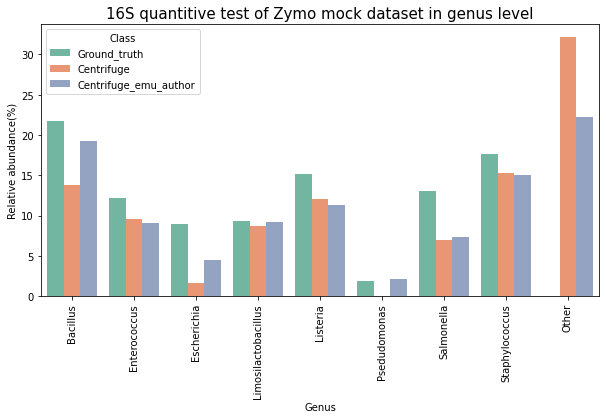

In [75]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Genus',y='Relative_abundance',hue='Class',data=zymo_benchmark,palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel('Relative abundance(%)')
plt.title('16S quantitive test of Zymo mock dataset in genus level',fontsize =15)
plt.savefig('16s_quantitative_test_zymo.png',dpi = 300,bbox_inches = "tight")

### Species level

In [8]:
genus = []
for i in zymo_ground_truth['Species'] :
    g = i.split(' ')[0]
    print(g)
    genus.append('g__' + g)
genus.remove('g__Psedudomonas')

Bacillus
Enterococcus
Escherichia
Limosilactobacillus
Listeria
Psedudomonas
Salmonella
Staphylococcus


/tmp/ipykernel_1800961/543591530.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Species'] = species
/tmp/ipykernel_1800961/543591530.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Class'] = ['Centrifuge'] * tmp.shape[0]
/tmp/ipykernel_1800961/543591530.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

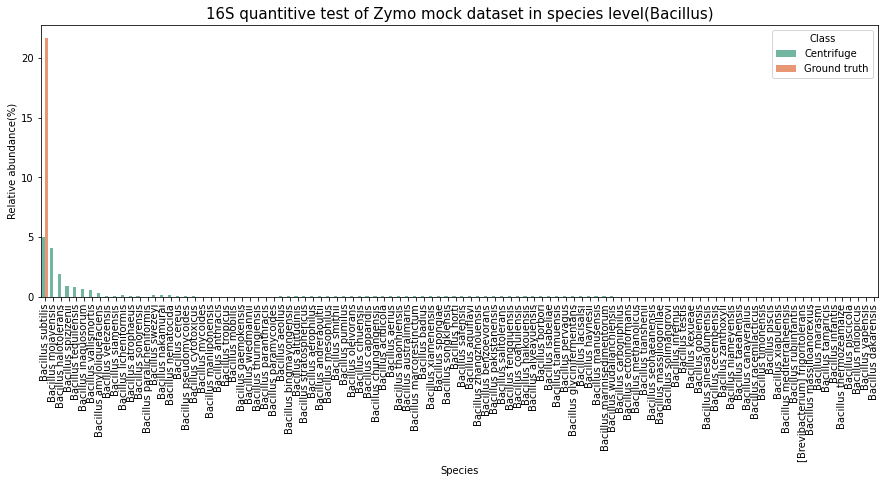

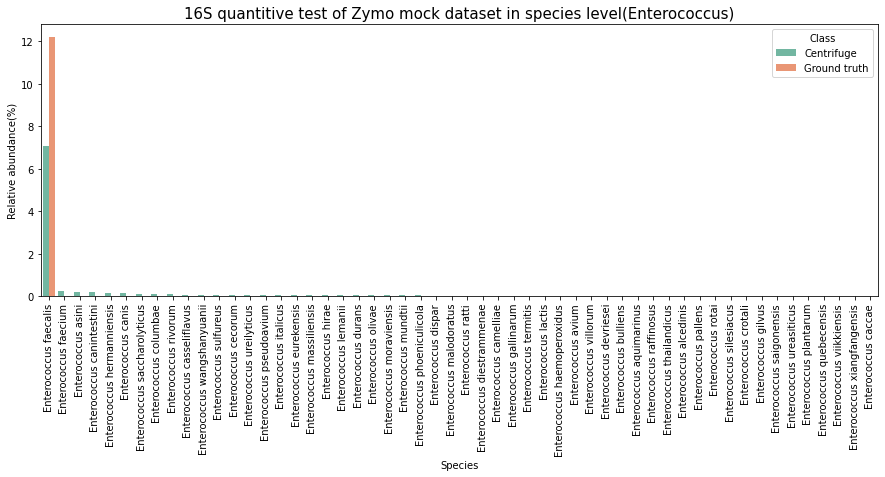

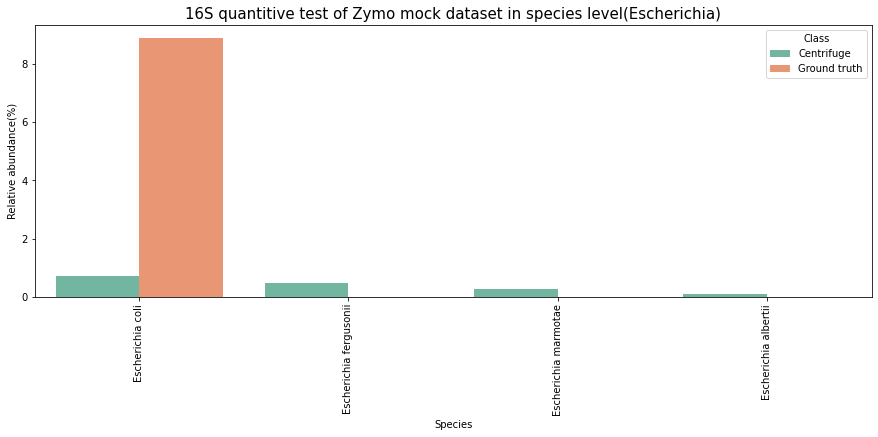

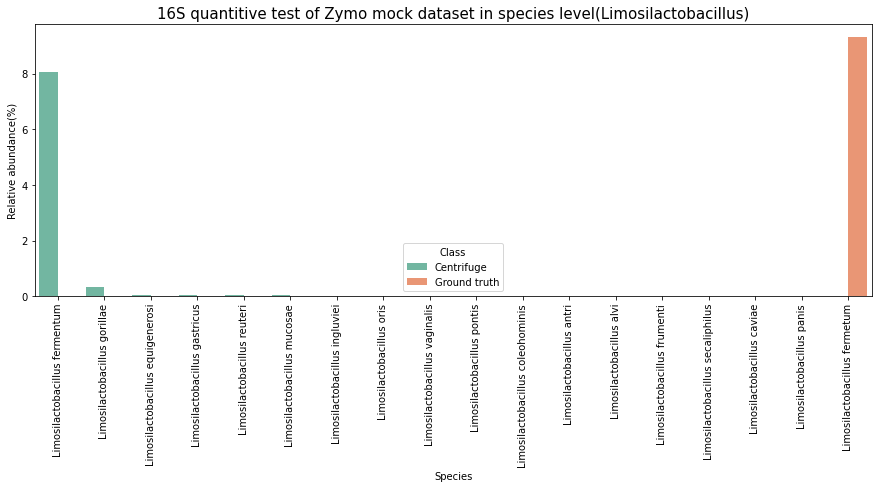

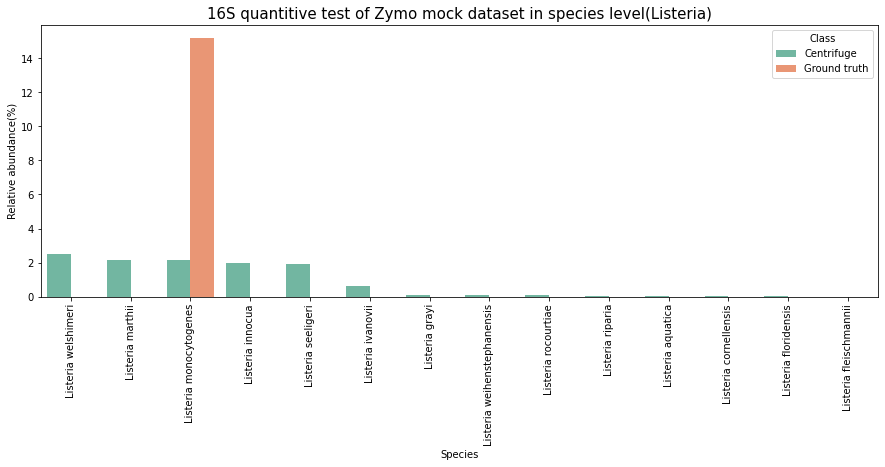

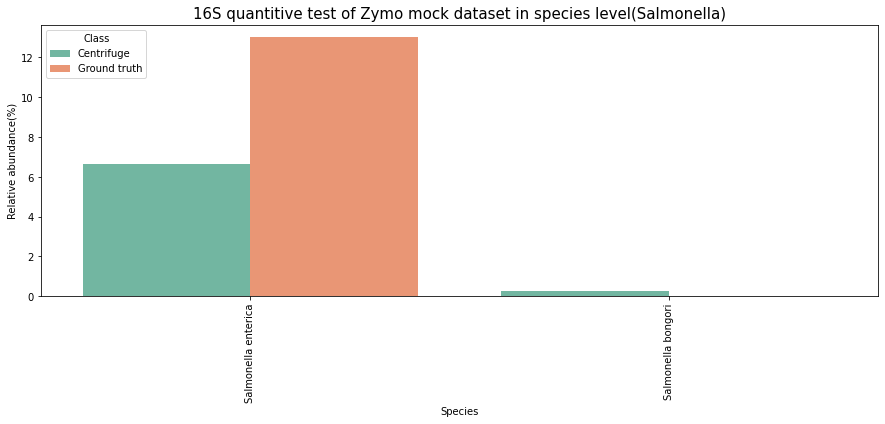

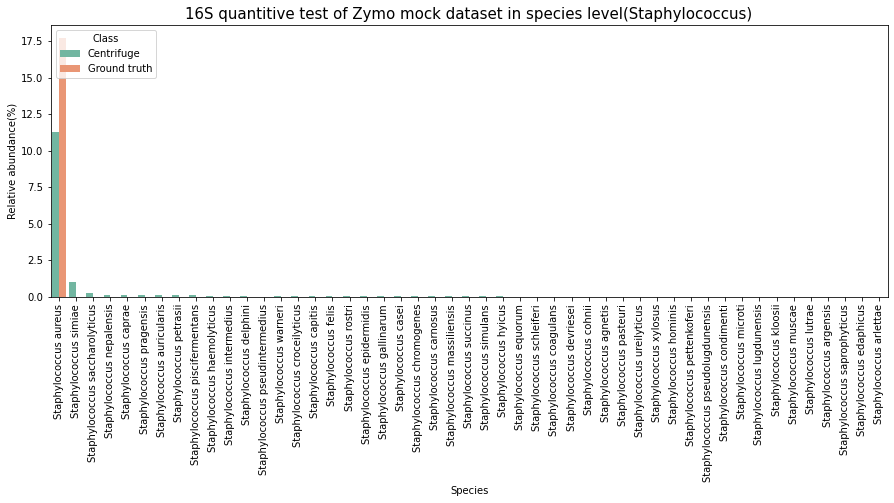

In [80]:
name = list(zymo_result.index)
for index,g in enumerate(genus) :
    pattern = '\S+' +g + '\S+'
    idx = [bool(re.search(pattern,x)) for x in name]
    tmp = zymo_result.loc[idx,:]
    #remove species subgroup
    tmp_name = tmp.index
    t_idx = [bool(re.search('group$',x)) for x in tmp_name]
    t_idx = [(x == False) for x in t_idx]
    #convert rowname to scientific name
    rowname = tmp.index
    species = []
    for i in rowname :
        n = i.split('|')[-1]
        gg = n.split('_')[2]
        s = n.split('_')[3]
        species.append(gg+' '+s)

    tmp['Species'] = species
    tmp['Class'] = ['Centrifuge'] * tmp.shape[0]
    new_row = pd.Series(data = {'Relative_abundnace' : zymo_ground_truth['Relative_abundance'][index],'Species' : zymo_ground_truth['Species'][index],'Class' : 'Ground truth'},name = genus[0])
    tmp = tmp.append(new_row)

    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='Species',y='Relative_abundnace',hue='Class',data=tmp,palette="Set2",ci=None)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    ax.set_ylabel('Relative abundance(%)')
    title = '16S quantitive test of Zymo mock dataset in species level' + '(' + g.split('_')[-1] +')'
    plt.title(title,fontsize =15)
    fig_name = 'tmp/16s_quantitative_test_zymo_in_species_level' + '_' + g.split('_')[-1] + '.png'
    plt.savefig(fig_name,dpi = 300,bbox_inches = "tight")

### emu output

In [55]:
emu_output = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/emu_output/ZymoBIOMICS_ont_rel-abundance-threshold-0.0001.tsv'
minimap2_output = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/minimap2_output/results_primary/ZymoBIOMICS_ont_primary_counts.tsv'
nanoclust_output = ''
centri_output = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/zymo_result.txt'
ground_truth = '/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/ground_truth/Zymo_mock_ground_truth.csv'

In [152]:
def format_mpa_report(mpa_report) :
    df = pd.read_csv(mpa_report,sep = '\t')
    df.columns = ['species','abundance']
    abundance_df = pd.DataFrame(columns=['kingdom','phylum','class','order','family','genus','species_group','species','strain'])
    header = df['species']
    col = ['kingdom','phylum','class','order','family','genus','species_group','species','strain']
    for i in header :
        group = re.search('group',i)
        if group == None :
            index = col[0:6] + col[7:]
        else :
            index = col
        s = i.split('|')
        #remove header like s__
        rm_header_s = [x[3:] for x in s]
        #remove subgroup
        check_subgroup = [bool(re.search('subgroup',x)) for x in rm_header_s]
        if True in check_subgroup :
            rm_idx = check_subgroup.index(True)
            rm_header_s.pop(rm_idx)
        x = pd.Series(rm_header_s,index = index[0:len(rm_header_s)])
        abundance_df = abundance_df.append(x,ignore_index=True)
    abundance_df['abundance'] = df['abundance']

    return abundance_df

In [149]:
df = pd.DataFrame(columns=['kingdom','phylum','class','order','family','genus','species_group','species','strain'])
header = centri_df['species']
col = ['kingdom','phylum','class','order','family','genus','species_group','species','strain']
for i in header :
    group = re.search('group',i)
    if group == None :
        index = col[0:6] + col[7:]
    else :
        index = col
    s = i.split('|')
    #remove header like s__
    rm_header_s = [x[3:] for x in s]
    #remove subgroup
    check_subgroup = [bool(re.search('subgroup',x)) for x in rm_header_s]
    if True in check_subgroup :
        rm_idx = check_subgroup.index(True)
        rm_header_s.pop(rm_idx)
    x = pd.Series(rm_header_s,index = index[0:len(rm_header_s)])
    df = df.append(x,ignore_index=True)
df['abundance'] = centri_df['abundance']

In [208]:
centri_df_subset 

,species,abundance
6,Bacillus subtilis,0.71
117,Enterococcus faecalis,7.05
172,Escherichia coli,0.70
177,Limosilactobacillus fermentum,8.07
198,Listeria monocytogenes,2.14
214,Salmonella enterica,6.64
217,Staphylococcus aureus,11.29


In [52]:
emu_df = pd.read_csv(emu_output,sep = '\t')
minimap_df = pd.read_csv(minimap2_output,sep='\t')
centri_df = format_mpa_report(centri_output)
zymo_ground_truth = pd.read_csv(ground_truth)
#remove abundance less than threshold
threshold = 0.0001
idx = minimap_df['abundance'] > threshold
minimap_df = minimap_df.loc[idx,:]
#change data format from bacillus_subtillis to bacillus subtillis
centri_df = centri_df.applymap(lambda x: x.replace('_',' ') if type(x) is str else x)
#change ground truth colname
zymo_ground_truth.columns = ['abundance','species']
centri_df.columns = ['species','abundance']

In [209]:
minimap_df_subset = minimap_df.iloc[:,0:2]
minimap_df_subset['Class'] = ['minimap2'] * minimap_df_subset.shape[0]
minimap_df_subset['abundance'] = minimap_df_subset['abundance'] * 100
emu_df_subset = emu_df.iloc[:,0:2]
emu_df_subset['Class'] = ['Emu'] * emu_df_subset.shape[0]
emu_df_subset['abundance'] = emu_df_subset['abundance'] * 100
zymo_ground_truth['Class'] = ['Ground_truth'] * zymo_ground_truth.shape[0]
#extract ground truth species from centri output
ground_truth = list(zymo_ground_truth['species'])
idx = [x in ground_truth for x in centri_df['species']]
centri_df_subset = centri_df.loc[idx,:]
centri_df_subset = centri_df_subset.loc[:,['species','abundance']]
centri_df_subset['Class'] = ['Centrifuge'] * centri_df_subset.shape[0]
merge_df = pd.concat([zymo_ground_truth,emu_df_subset,minimap_df_subset,centri_df_subset])


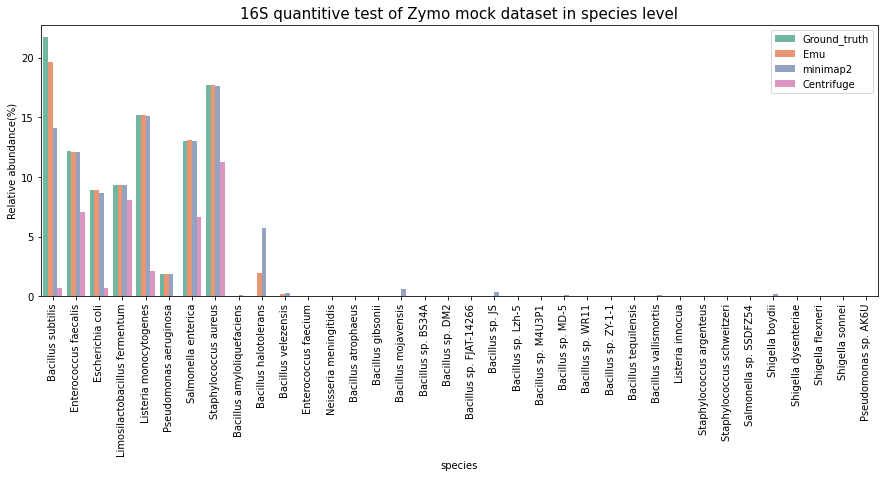

In [215]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='species',y='abundance',hue='Class',data=merge_df,palette="Set2",ci=None)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel('Relative abundance(%)')
title = '16S quantitive test of Zymo mock dataset in species level' 
plt.title(title,fontsize =15)
plt.legend(loc='upper right')
output_path = '/home/bruce1996/data/Yi-Fung-Chuang/'
fig_name = output_path + 'tmp/16s_quantitative_test_zymo_in_species_level.png'
plt.savefig(fig_name,dpi = 300,bbox_inches = "tight")